# Debugging Factor Analysis Implementation

This notebook investigates the Factor Analysis implementation step by step, focusing on:
1. Data generation
2. E-step computation
3. M-step updates
4. Full model fitting

In [1]:
import numpy as np
try:
    from sklearn.decomposition import FactorAnalysis as sklearn_fa
except:
    !pip install scikit-learn
    from sklearn.decomposition import FactorAnalysis as sklearn_fa
try:
    import procrustes
except:
    !pip install qc-procrustes
    import procrustes

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns 
import equinox as eqx
from jax import config
from sppcax.models import PPCA, PFA
from sppcax.distributions import MultivariateNormal, MultivariateNormalGamma
from sppcax.models import fit, transform, inverse_transform

# For better visualization
%matplotlib inline
sns.set_theme('notebook', style='dark', palette="deep")
config.update("jax_enable_x64", True)

## 1. Data Generation

First, let's generate synthetic data with known structure:

Data shapes:
X: (100, 10)
Z_true: (100, 3)
W_true: (3, 10)


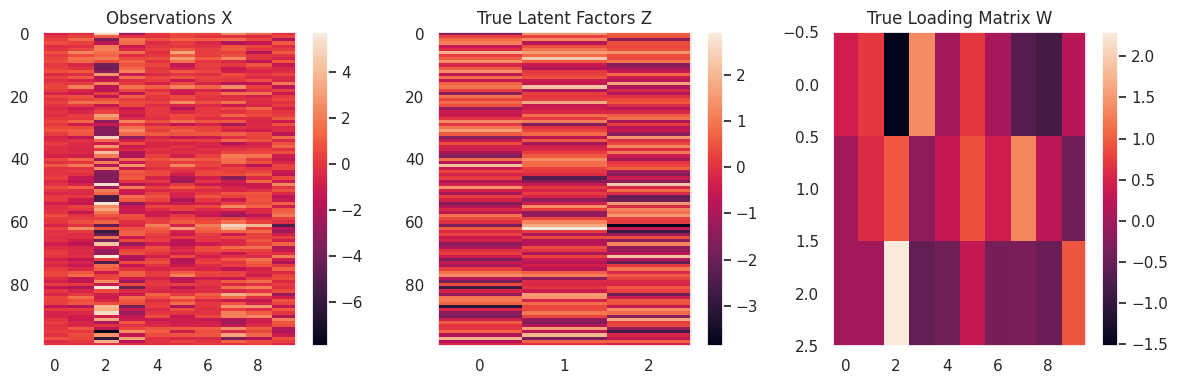

In [3]:
# Set random seed for reproducibility
key = jr.PRNGKey(0)

# Data dimensions
n_samples = 100
n_features = 10
n_components = 3

assert (n_features - n_components)**2 >= n_features + n_components

mask = jnp.transpose(jnp.clip(jnp.arange(n_features), a_max=n_components)[..., None] >= jnp.arange(n_components))

# Generate true latent factors
key, subkey = jr.split(key)
Z_true = jr.normal(subkey, (n_samples, n_components))

# Generate true loading matrix with some features being noise
key, subkey = jr.split(key)
W_true = jr.normal(subkey, (n_components, n_features)) * mask

# Generate observations with noise
key, subkey = jr.split(key)
noise = 0.1 * jr.normal(subkey, (n_samples, n_features))
X = Z_true @ W_true + noise

print("Data shapes:")
print(f"X: {X.shape}")
print(f"Z_true: {Z_true.shape}")
print(f"W_true: {W_true.shape}")

# Visualize the data
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Observations X')
plt.colorbar()

plt.subplot(132)
plt.imshow(Z_true, aspect='auto')
plt.title('True Latent Factors Z')
plt.colorbar()

plt.subplot(133)
plt.imshow(W_true, aspect='auto')
plt.title('True Loading Matrix W')
plt.colorbar()

plt.tight_layout()

The Procrustes error for the loading matrix is 1.1283958694033875


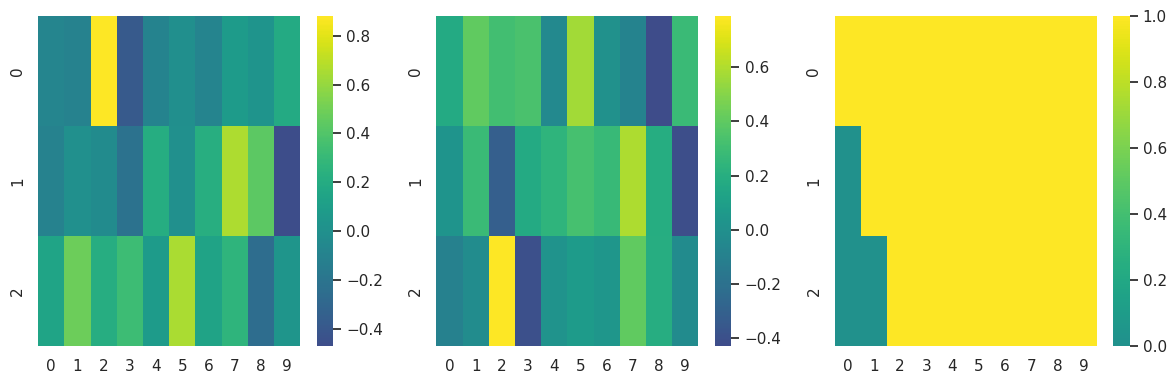

In [4]:
z_dim = n_components
u, s, v = jnp.linalg.svd(X - X.mean(0), full_matrices=False)
pca_w = v[:z_dim]

proc_trans = procrustes.orthogonal(np.asarray(pca_w.T), np.asarray(mask.T).astype(jnp.float32), scale=True)
print(f"The Procrustes error for the loading matrix is {proc_trans.error}")

# Heatmap of transformed loading matrix
pca_w_trans = proc_trans.t.T @ pca_w
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.heatmap(pca_w, cmap='viridis', fmt = ".2f", center = 0, ax=axes[0])
sns.heatmap(pca_w_trans, cmap='viridis', fmt = ".2f", center = 0, ax=axes[1])
sns.heatmap(mask, cmap='viridis', fmt = ".2f", center = 0, ax=axes[2])
fig.tight_layout()

The Procrustes error for the loading matrix is 1.2901691077796207


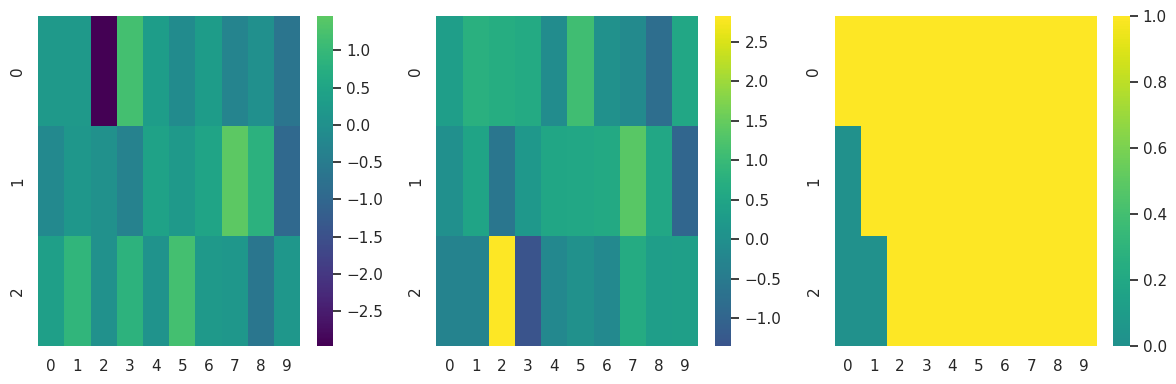

In [5]:
fa = sklearn_fa(n_components=z_dim, rotation='varimax')
res = fa.fit(X)

proc_trans = procrustes.orthogonal(np.asarray(res.components_.T), np.asarray(mask.T).astype(jnp.float32), scale=True)
print(f"The Procrustes error for the loading matrix is {proc_trans.error}")

# Heatmap of transformed loading matrix
fa_w_trans = proc_trans.t.T @ res.components_
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.heatmap(res.components_, cmap='viridis', fmt = ".2f", center = 0, ax=axes[0])
sns.heatmap(fa_w_trans, cmap='viridis', fmt = ".2f", center = 0, ax=axes[1])
sns.heatmap(mask, cmap='viridis', fmt = ".2f", center = 0, ax=axes[2])
fig.tight_layout()

## 2. E-step Investigation

Let's initialize a model and examine each part of the E-step computation:

E-step computation:
Ez + Ezz shape: (100, 12)


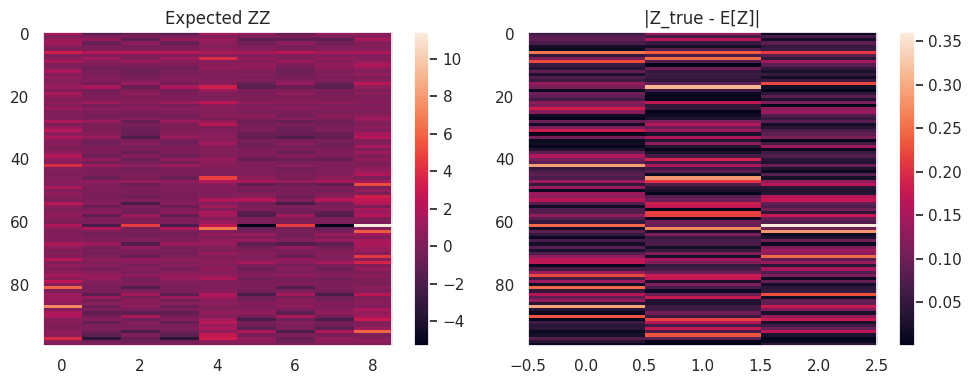

In [6]:
from sppcax.models import e_step

# Initialize model with known parameters
model = PPCA(n_components=n_components, n_features=n_features)

W_dist = MultivariateNormalGamma(
    loc=W_true.mT,  # Use true W for initialization
    scale_tril=jnp.eye(n_components)/100,
    mask=model.W_dist.mvn.mask,
    alpha=model.W_dist.gamma.alpha,
    beta=1.0
)

model = eqx.tree_at(lambda x: x.W_dist, model, W_dist)
mean = X.mean(0)
model = eqx.tree_at(lambda x: x.mean_, model, mean)

# Step through E-step computation
print("E-step computation:")

# Compute expectations
qz = e_step(model, X)
exp_stats = qz.expected_sufficient_statistics
print(f"Ez + Ezz shape: {exp_stats.shape}")

# Visualize E-step results
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(exp_stats[:, n_components:], aspect='auto')
plt.title('Expected ZZ')
plt.colorbar()

plt.subplot(122)
plt.imshow(jnp.abs(Z_true - Z_true.mean(0) - qz.mean), aspect='auto')
plt.title('|Z_true - E[Z]|')
plt.colorbar()

plt.tight_layout()
plt.show()

E-step computation:
Ez + Ezz shape: (100, 12)


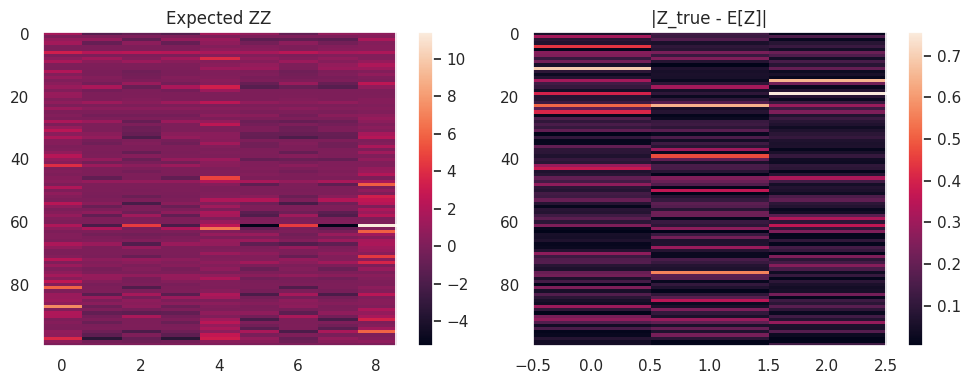

In [7]:
from sppcax.models import e_step

# Initialize model with known parameters
model = PPCA(n_components=n_components, n_features=n_features, bmr_e_step=True)

W_dist = MultivariateNormalGamma(
    loc=W_true.mT,  # Use true W for initialization
    scale_tril=jnp.eye(n_components)/100,
    mask=model.W_dist.mvn.mask,
    alpha=model.W_dist.gamma.alpha,
    beta=1.0
)

model = eqx.tree_at(lambda x: x.W_dist, model, W_dist)
mean = X.mean(0)
model = eqx.tree_at(lambda x: x.mean_, model, mean)

# Step through E-step computation
print("E-step computation:")

# Compute expectations
key, _key = jr.split(key)
qz = e_step(model, X, use_bmr=True, key=_key)
exp_stats = qz.expected_sufficient_statistics
print(f"Ez + Ezz shape: {exp_stats.shape}")

# Visualize E-step results
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(exp_stats[:, n_components:], aspect='auto')
plt.title('Expected ZZ')
plt.colorbar()

plt.subplot(122)
plt.imshow(jnp.abs(Z_true - Z_true.mean(0) - qz.mean), aspect='auto')
plt.title('|Z_true - E[Z]|')
plt.colorbar()

plt.tight_layout()
plt.show()

## 3. M-step Investigation

Now let's examine the M-step updates:

M-step computation:


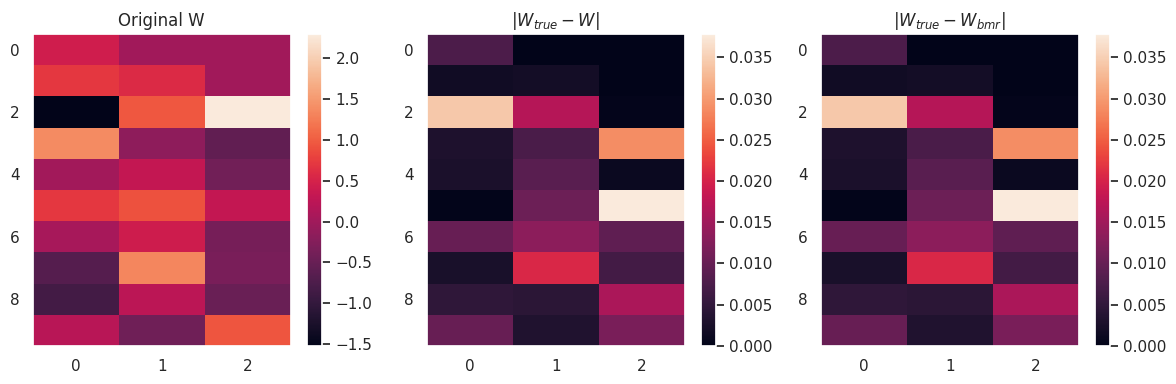

noise precision 5.496360302303526 5.647473638095533
expected tau [0.27980865 0.37914118 0.20115154] [0.27234466 0.36904043 0.19577871]


In [8]:
from sppcax.models import m_step

# Step through M-step computation
print("M-step computation:")

# 4. Update model
updated_model = m_step(model, X, qz, use_bmr=False)
updated_model2 = m_step(model, X, qz, use_bmr=True)

# Visualize M-step results
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(model.W_dist.mean, aspect='auto')
plt.title('Original W')
plt.colorbar()

plt.subplot(132)
plt.imshow(jnp.abs(W_true.mT - updated_model.W_dist.mean), aspect='auto')
plt.title(r'$|W_{true} - W|$')
plt.colorbar()

plt.subplot(133)
plt.imshow(jnp.abs(W_true.mT - updated_model2.W_dist.mean), aspect='auto')
plt.title(r'$|W_{true} - W_{bmr}|$')
plt.colorbar()

plt.tight_layout()
plt.show()

print('noise precision', updated_model2.noise_precision.mean, updated_model.noise_precision.mean)
print('expected tau', updated_model2.W_dist.gamma.mean, updated_model.W_dist.gamma.mean)

## 4. Full Model Fitting

Let's test the complete fitting procedure:

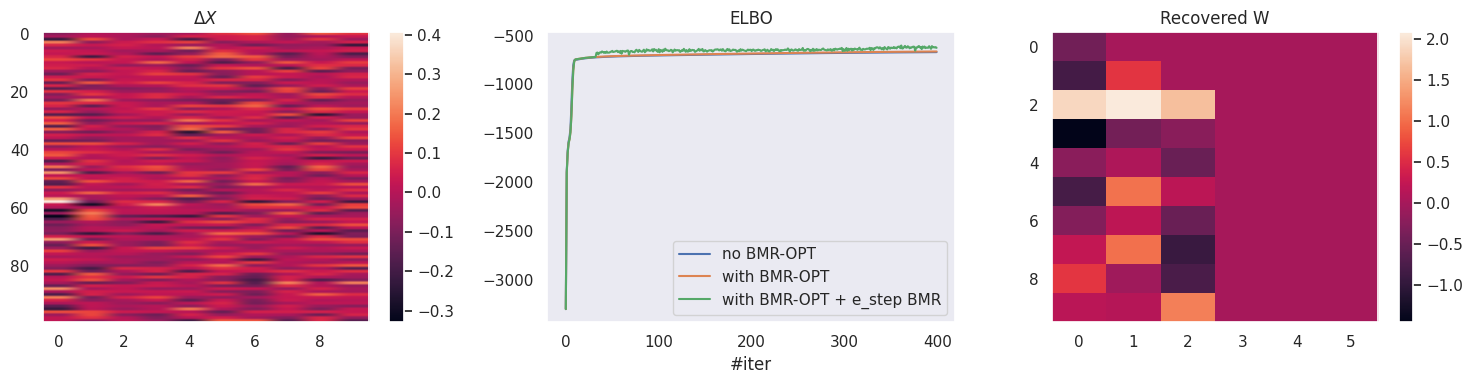

Reconstruction error: 0.007468
ARD posterior [4.85072038e-02 4.79007619e-02 4.93146057e-02 3.37438212e+04
 3.38608178e+04 3.38460342e+04]
Posterior noise precision 26.76011457989904


In [9]:
# Test probabilistic Principle Component Analysis
# Initialize model
model1 = PPCA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=False)
model2 = PPCA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=True)
model3 = PPCA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=True, bmr_e_step=True)

# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, tol=1e-2, n_iter=400, key=key)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3][m]

# Transform data
qz = transform(f_model, X)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X - X_reconstructed, aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.W_dist.gamma.mean)
print("Posterior noise precision", f_model.noise_precision.mean)

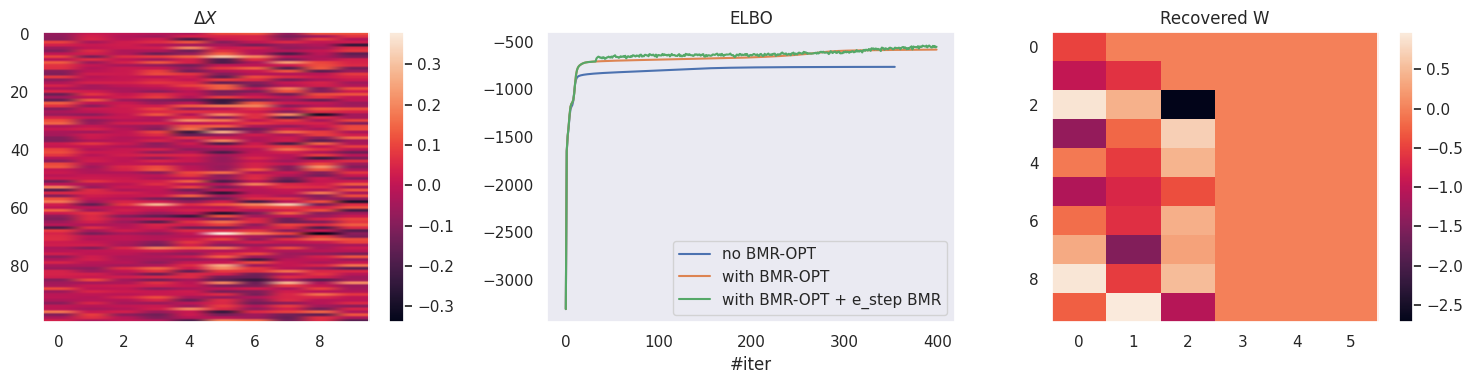

Reconstruction error: 0.007809
ARD posterior [3.16438415e-02 5.92760439e-02 1.89696931e-02 3.40576387e+04
 3.43068803e+04 3.42194209e+04]
Posterior noise precision [134.09327491 131.00298571  48.05762312  44.96289014  34.25355826
  18.77748265  25.92471952  16.85014457  21.28988565  21.37949779]


In [10]:
# Test probabilistic Factor Analysis
# Initialize model
model1 = PFA(n_components=2 * n_components, n_features=n_features)
model2 = PFA(n_components=2 * n_components, n_features=n_features, optimize_with_bmr=True)
model3 = PFA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=True, bmr_e_step=True)


# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, tol=1e-2, n_iter=400, key=key)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3][m]  

# Transform data
qz = transform(f_model, X)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X - X_reconstructed, aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.W_dist.gamma.mean)
print("Posterior noise precision", f_model.noise_precision.mean)

## 5. Working with missing data

We illustrate here how to mask missing data.

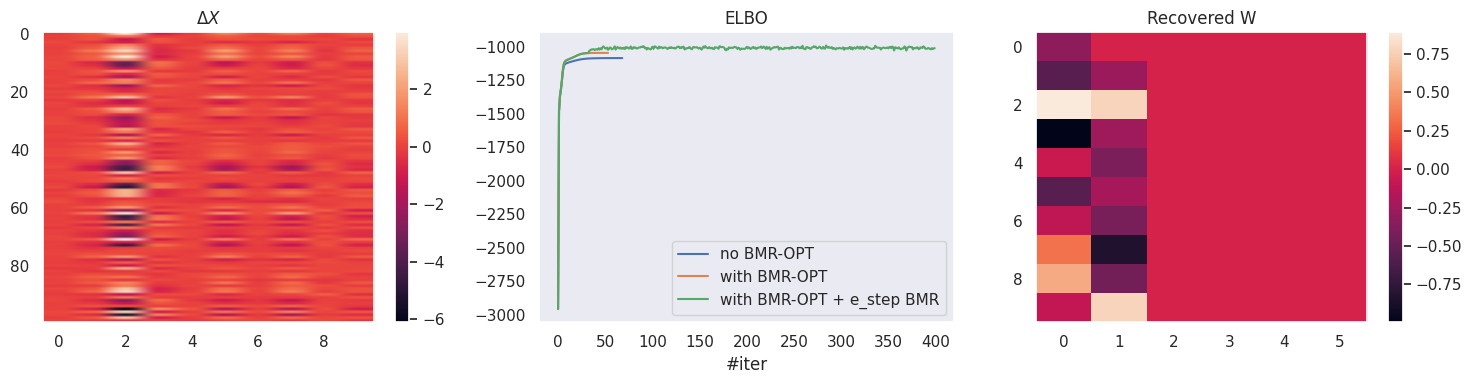

Reconstruction error: 0.752265
ARD posterior [1.09824990e+00 1.12852690e+00 2.73931830e+04 2.75278157e+04
 2.75329421e+04 2.73072377e+04]
Posterior noise precision [35.12127991  3.69652306  0.17492936  1.73498937 12.88393677  1.19630472
  9.99344495  1.25093862  5.19171386  2.76565403]


In [11]:
# mask 20% of the observed features
key, _key = jr.split(key)
data_mask = jr.bernoulli(_key, p=.9, shape=X.shape)

# Initialize model
model1 = PFA(n_components=2 * n_components, n_features=n_features, data_mask=data_mask)
model2 = PFA(n_components=2 * n_components, n_features=n_features, data_mask=data_mask, optimize_with_bmr=True)
model3 = PFA(n_components=2 * n_components, n_features=n_features, data_mask=data_mask, optimize_with_bmr=True, bmr_e_step=True)

# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, tol=1e-2, n_iter=400, key=key)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3][m]  

# Transform data
qz = transform(f_model, X, use_data_mask=True)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow((X - X_reconstructed) , aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean(jnp.square((X - X_reconstructed)))
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.W_dist.gamma.mean)
print("Posterior noise precision", f_model.noise_precision.mean)

# NOTE: This is slightly strange, probably a bug somewhere. 
# If 1% of data is masked, the convergance is faster then with a full data set, 
# However, if we increase the number of masked datapoints the performance becomes
# worse (more components get pruned) while convergence is faster. 

## 6. Passing uncertain measurements

Here, we illustrate here how to pass data with uncertainty associated with measurements.

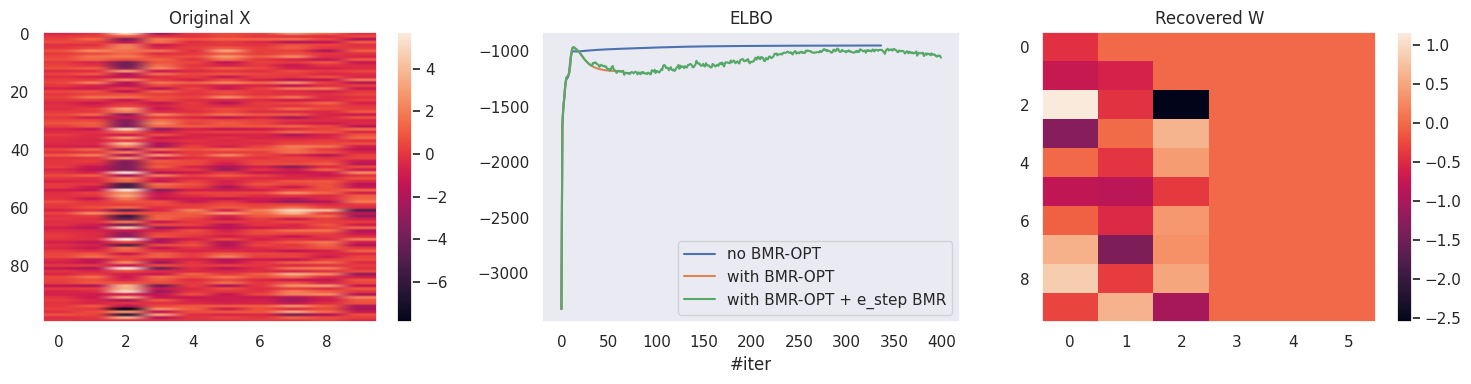

Reconstruction error: 0.007020
ARD posterior [1.09153716e-01 1.64638114e-01 7.57250170e-02 3.33455743e+04
 3.35187416e+04 3.35179184e+04]
Posterior noise precision [35.82558264 26.02153942 10.73158009 19.65241915 20.80692419 12.56171317
 17.44087838 11.04668402 14.59727318 14.17029923]


In [7]:
# add uncertainty to observations
X_dist = MultivariateNormal(loc=X, precision=50*jnp.eye(n_features))

# Initialize model
model1 = PFA(n_components=2 * n_components, n_features=n_features)
model2 = PFA(n_components=2 * n_components, n_features=n_features, optimize_with_bmr=True)
model3 = PFA(n_components=2*n_components, n_features=n_features, bmr_e_step=True)
model4 = PFA(n_components=2*n_components, n_features=n_features, optimize_with_bmr=True, bmr_e_step=True)


# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X_dist, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X_dist, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X_dist, tol=1e-2, n_iter=400, key=key)

key, _key = jr.split(key)
fitted_model4, elbos4 = fit(model4, X_dist, tol=1e-2, n_iter=400, key=key)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1], elbos4[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3, fitted_model4][m]  

# Transform data
qz = transform(f_model, X_dist)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='e_step BMR')
plt.plot(elbos4, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.W_dist.gamma.mean)
print("Posterior noise precision", f_model.noise_precision.mean)

## 7. Model pruning with Bayesian model reduction

Here, we illustrate the pruning of the parameters of the loading matrix with BMR. We will
compare variants with and without BMR based optimisation of $q(\pmb{\tau})$ and $q(\pmb{\psi})$ during the VBM step. 

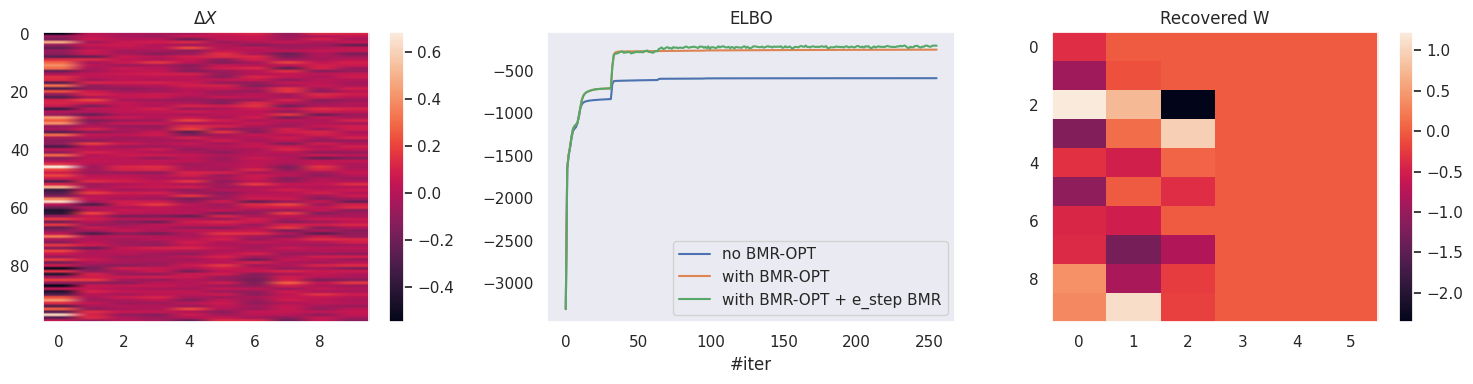

Reconstruction error: 0.012791
ARD posterior [1.84678484e-02 1.85867555e-02 1.25299737e-02 3.72469200e+03
 3.03251393e+03 3.03360076e+03]
Posterior noise precision [ 14.43648887  83.30495273  68.15838239 122.41353391 113.25906152
 103.31253504 137.74497595  65.68954038 114.90485262 111.61971466]


In [6]:
# Initialize model - note that BMR pruning requires random state as it uses Gibbs sampling for prining
# Initialize model
model1 = PFA(n_components=2 * n_components, n_features=n_features, bmr_m_step=True)
model2 = PFA(n_components=2 * n_components, n_features=n_features, optimize_with_bmr=True, bmr_m_step=True)
model3 = PFA(n_components=2 * n_components, n_features=n_features, optimize_with_bmr=True, bmr_e_step=True, bmr_m_step=True)


# Fit model
key, _key = jr.split(key)
fitted_model1, elbos1 = fit(model1, X, tol=1e-3, n_iter=256, bmr_frequency=32, key=key)

key, _key = jr.split(key)
fitted_model2, elbos2 = fit(model2, X, tol=1e-3, n_iter=256, bmr_frequency=32, key=key)

key, _key = jr.split(key)
fitted_model3, elbos3 = fit(model3, X, tol=1e-3, n_iter=256, bmr_frequency=32, key=key)

m = jnp.argmax(jnp.array([elbos1[-1], elbos2[-1], elbos3[-1]])).item()
f_model = [fitted_model1, fitted_model2, fitted_model3][m]

# Transform data
qz = transform(f_model, X)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(f_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X - X_reconstructed, aspect='auto')
plt.title(r'$\Delta X$')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos1, label='no BMR-OPT')
plt.plot(elbos2, label='with BMR-OPT')
plt.plot(elbos3, label='with BMR-OPT + e_step BMR')
plt.title('ELBO')
plt.xlabel('#iter')
plt.legend()

plt.subplot(133)
plt.imshow(f_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", f_model.W_dist.gamma.mean)
print("Posterior noise precision", f_model.noise_precision.mean)